In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import warnings
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import RFECV

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [761]:
xls = pd.ExcelFile('./Dataset/2019 County Health Rankings Data - v2.xls')
df = pd.read_csv('./Dataset/analytic_data2019.csv')
y = pd.read_excel(xls, 'Outcomes & Factors Rankings')
#df2 = pd.read_excel(xls, 'Outcomes & Factors SubRankings')
df3 = pd.read_excel(xls, 'Ranked Measure Data',skiprows=1)
life_exp = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [762]:
df3 = utils.drop_cols(df3,300)

cols_drop = [col for col in df3.columns if '95% CI' in col or "Quartile" in col or "Percentile" in col]
cols_drop.extend([col for col in df3.columns if 'numerator' in col or 'denominator' in col])
df3.drop(cols_drop,axis=1,inplace=True)
display(df3.head())
df3.shape

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% Smokers,% Obese,...,Injury Death Rate,Average Daily PM2.5,Presence of violation,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,# Workers who Drive Alone,% Long Commute - Drives Alone
0,1001,Alabama,Autauga,8824.057123,18.411124,4.200578,4.306739,8.475719,19.124658,37.5,...,74.031808,11.7,No,14.954646,13.205223,2.451581,0.637411,85.965057,20911,38.3
1,1003,Alabama,Baldwin,7224.632160,18.060458,4.098748,4.249649,8.338683,16.795485,31.0,...,69.374289,10.3,Yes,13.831725,12.569278,1.072802,0.607246,84.719423,74415,40.5
2,1005,Alabama,Barbour,9586.165037,25.773416,5.067438,4.634994,10.952624,21.540878,44.3,...,72.900134,11.5,No,15.455531,13.674263,2.006508,0.813449,83.404353,7242,33.8
3,1007,Alabama,Bibb,11783.543675,19.996912,4.363377,4.315710,11.105003,19.916404,37.8,...,100.077937,11.2,No,10.960854,10.808081,0.199288,0.284698,86.365902,6930,48.6
4,1009,Alabama,Blount,10908.101822,21.095323,4.512753,4.701599,7.926829,19.652158,34.4,...,105.197227,11.7,No,10.401153,7.945879,1.724718,0.912803,86.792275,18426,59.7


(3142, 62)

In [769]:
all(df3['FIPS'] == life_exp['FIPS'])

True

In [636]:
df = utils.drop_cols(df,2000)

In [637]:
cols_drop = [col for col in life_exp.columns if '95% CI' in col]
life_exp.drop(cols_drop,axis=1,inplace=True)


In [638]:
life_exp = utils.drop_cols(life_exp,1000)

In [639]:
cols_drop = [col for col in df.columns if 'CI' in col]
cols_drop.extend([col for col in df.columns if 'numerator' in col or 'denominator' in col])

fin_df = df.drop(cols_drop,axis=1)


,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death (Black),Premature death (White),...,% 65 and older raw value,% Non-Hispanic African American raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% Non-Hispanic white raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
0,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_race_black,v001_race_white,...,v053_rawvalue,v054_rawvalue,v055_rawvalue,v081_rawvalue,v080_rawvalue,v056_rawvalue,v126_rawvalue,v059_rawvalue,v057_rawvalue,v058_rawvalue
1,00,000,00000,US,United States,2019,NaN,6900.630354,NaN,NaN,...,0.1561427218,0.1248080179,0.0126007164,0.0582988669,0.0024114976,0.1809740813,0.6072810456,0.0445539242,0.5075263299,NaN
2,01,000,01000,AL,Alabama,2019,NaN,9917.2328984,NaN,NaN,...,0.1648846597,0.2652090457,0.0069968759,0.0146341954,0.0010747224,0.0432961957,0.6557985471,0.0107484565,0.5159059537,0.409631829
3,01,001,01001,AL,Autauga County,2019,1,8824.0571232,10471.252986,8706.6588323,...,0.1511963102,0.1925446815,0.004756414,0.0127918709,0.0010449697,0.0285745172,0.7447391179,0.0082854831,0.513422456,0.4200216232
4,01,003,01003,AL,Baldwin County,2019,1,7224.6321603,10042.472874,7277.7807271,...,0.1994704366,0.0895319525,0.0077600316,0.0115647986,0.0006866452,0.0455020035,0.8304738793,0.0045451229,0.5145277198,0.4227909911


In [640]:
fin_df = utils.drop_cols(fin_df,300)


,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,...,% 65 and older raw value,% Non-Hispanic African American raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% Non-Hispanic white raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
0,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v002_rawvalue,v036_rawvalue,...,v053_rawvalue,v054_rawvalue,v055_rawvalue,v081_rawvalue,v080_rawvalue,v056_rawvalue,v126_rawvalue,v059_rawvalue,v057_rawvalue,v058_rawvalue
1,00,000,00000,US,United States,2019,NaN,6900.630354,NaN,NaN,...,0.1561427218,0.1248080179,0.0126007164,0.0582988669,0.0024114976,0.1809740813,0.6072810456,0.0445539242,0.5075263299,NaN
2,01,000,01000,AL,Alabama,2019,NaN,9917.2328984,0.2140240566,4.4004575204,...,0.1648846597,0.2652090457,0.0069968759,0.0146341954,0.0010747224,0.0432961957,0.6557985471,0.0107484565,0.5159059537,0.409631829
3,01,001,01001,AL,Autauga County,2019,1,8824.0571232,0.1841112436,4.2005779826,...,0.1511963102,0.1925446815,0.004756414,0.0127918709,0.0010449697,0.0285745172,0.7447391179,0.0082854831,0.513422456,0.4200216232
4,01,003,01003,AL,Baldwin County,2019,1,7224.6321603,0.1806045782,4.0987477691,...,0.1994704366,0.0895319525,0.0077600316,0.0115647986,0.0006866452,0.0455020035,0.8304738793,0.0045451229,0.5145277198,0.4227909911


In [641]:
nul_cols = []
for col in fin_df.columns:
    if any(fin_df[col].isna()):
        
        nul_cols.append(col)
for col in nul_cols:
    try:
        fin_df.fillna(fin_df[col].median(), inplace=True)
    except:
        continue

### try data imputation

In [642]:
merged_df = life_exp.set_index('FIPS').join(fin_df.set_index('5-digit FIPS Code'), how="inner")
#merged_df = merged_df.join(df3.set_index('FIPS'), how="inner",lsuffix='_left', rsuffix='_right')
#cols_drop = [col for col in merged_df.columns if '_right' in col]
#merged_df.drop(cols_drop,axis=1,inplace=True)
merged_df.reset_index(inplace=True)

In [643]:
merged_df.shape

(2138, 130)

### Gather dataframes

In [644]:
# drop cols with lots of nuls, categorical vars, cols we do not need in our model
cols_to_drop = ['FIPS',
 '# HIV Cases',
 '# Limited Access',
 '# Motor Vehicle Deaths',
 '# Uninsured', 
 '# Uninsured.1',
 'Segregation Index',
 '# Firearm Fatalities',
 'Firearm Fatalities Rate',
 '# Households with Severe Cost Burden',
 '# Rural','% 65 and over', '# African American', '% African American',
       '# American Indian/Alaskan Native', '% American Indian/Alaskan Native',
       '# Asian', '% Asian', '# Native Hawaiian/Other Pacific Islander',
       '% Native Hawaiian/Other Pacific Islander', '# Hispanic', '% Hispanic',
       '# Non-Hispanic White', '% Non-Hispanic White',
       '# Not Proficient in English', '% Not Proficient in English','Household income (Hispanic)',
       'Household income (White)', 'HIV Prevalence Rate','MV Mortality Rate','Other PCP Ratio','# Food Insecure','# Homeowners']

In [645]:
second_df = life_exp

In [646]:


life_exp.drop(cols_to_drop,axis=1,inplace=True)



,State,County,Life Expectancy,# Deaths,Age-Adjusted Mortality,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Limited Access,...,% Uninsured.1,Other PCP Rate,Household Income,% Free or Reduced Lunch,% Homeowners,% Severe Housing Cost Burden,Population,% < 18,% Female,% Rural
0,Alabama,Autauga,76.330589,815.0,438.7,12.824434,12.638357,14.2,13.4,11.991125,...,2.476190,30.62842,58343.0,47.931664,73.287736,12.645206,55504,23.937014,51.342246,42.002162
1,Alabama,Baldwin,78.599498,2827.0,348.4,12.622002,12.822558,11.3,12.3,5.424427,...,3.238027,52.20385,56607.0,45.079131,72.859338,12.795922,212628,21.848487,51.452772,42.279099
2,Alabama,Barbour,75.779457,451.0,469.8,16.216160,14.632311,18.0,23.2,10.739667,...,2.901424,23.74357,32490.0,73.769808,62.506800,13.586765,25270,20.763751,47.229917,67.789635
3,Alabama,Bibb,73.928271,445.0,563.7,13.162968,12.854036,14.9,15.8,2.601627,...,2.619447,92.64161,45795.0,65.329687,75.361481,8.733889,22668,20.606141,46.453150,68.352607
4,Alabama,Blount,74.597767,1050.0,501.8,13.720057,13.827943,14.3,11.0,2.880150,...,3.430136,18.96127,48253.0,53.311793,78.521025,8.194495,58013,23.349939,50.688639,89.951502


In [647]:
nul_cols = []
for col in life_exp.columns:
    if any(life_exp[col].isna()):
        
        nul_cols.append(col)
nul_cols

['Life Expectancy',
 '# Deaths',
 'Age-Adjusted Mortality',
 '% Limited Access',
 '% Uninsured',
 '% Uninsured.1',
 'Other PCP Rate',
 'Household Income',
 '% Free or Reduced Lunch',
 '% Severe Housing Cost Burden',
 '% Rural']

In [648]:
for col in nul_cols:
    try:
        life_exp.fillna(life_exp[col].median(), inplace=True)
    except:
        continue

,State,County,Life Expectancy,# Deaths,Age-Adjusted Mortality,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Limited Access,...,% Uninsured.1,Other PCP Rate,Household Income,% Free or Reduced Lunch,% Homeowners,% Severe Housing Cost Burden,Population,% < 18,% Female,% Rural
0,Alabama,Autauga,76.330589,815.0,438.7,12.824434,12.638357,14.2,13.4,11.991125,...,2.476190,30.62842,58343.0,47.931664,73.287736,12.645206,55504,23.937014,51.342246,42.002162
1,Alabama,Baldwin,78.599498,2827.0,348.4,12.622002,12.822558,11.3,12.3,5.424427,...,3.238027,52.20385,56607.0,45.079131,72.859338,12.795922,212628,21.848487,51.452772,42.279099
2,Alabama,Barbour,75.779457,451.0,469.8,16.216160,14.632311,18.0,23.2,10.739667,...,2.901424,23.74357,32490.0,73.769808,62.506800,13.586765,25270,20.763751,47.229917,67.789635
3,Alabama,Bibb,73.928271,445.0,563.7,13.162968,12.854036,14.9,15.8,2.601627,...,2.619447,92.64161,45795.0,65.329687,75.361481,8.733889,22668,20.606141,46.453150,68.352607
4,Alabama,Blount,74.597767,1050.0,501.8,13.720057,13.827943,14.3,11.0,2.880150,...,3.430136,18.96127,48253.0,53.311793,78.521025,8.194495,58013,23.349939,50.688639,89.951502


In [649]:
for col in nul_cols:
    try:
        merged_df.fillna(merged_df[col].median(), inplace=True)
    except:
        continue


Text(0.5, 0, 'States')

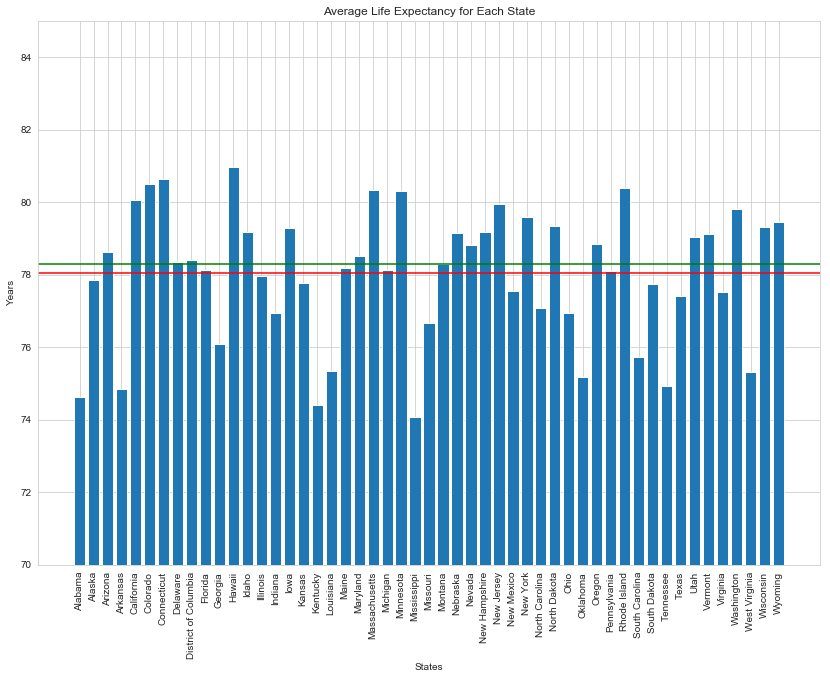

In [650]:
plt.figure(figsize=(14,10))
states = life_exp.groupby('State').mean()['Life Expectancy']
plt.bar(states.index,states)
plt.axhline(y=states.mean(),c='r')
plt.axhline(y=states.median(),c='g')
plt.xticks(rotation=90)
plt.ylim([70,85])
plt.title("Average Life Expectancy for Each State")
plt.ylabel("Years")
plt.xlabel("States")

Text(0.5, 0, 'States')

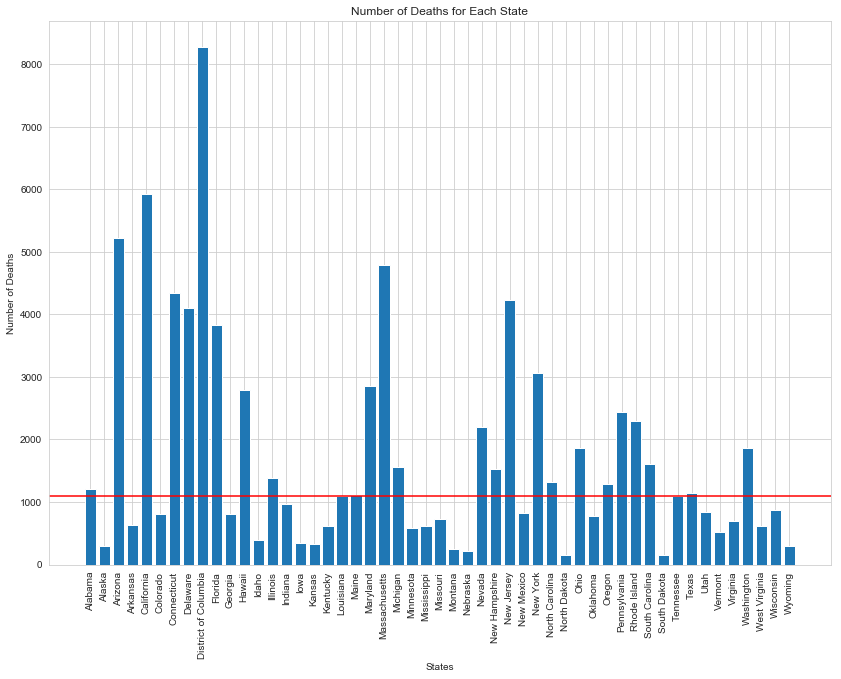

In [651]:
plt.figure(figsize=(14,10))
deaths = life_exp.groupby('State').mean()['# Deaths']
plt.bar(states.index,deaths)
plt.axhline(y=deaths.median(),c='r')
plt.xticks(rotation=90)
plt.title("Number of Deaths for Each State")
plt.ylabel("Number of Deaths")
plt.xlabel("States")

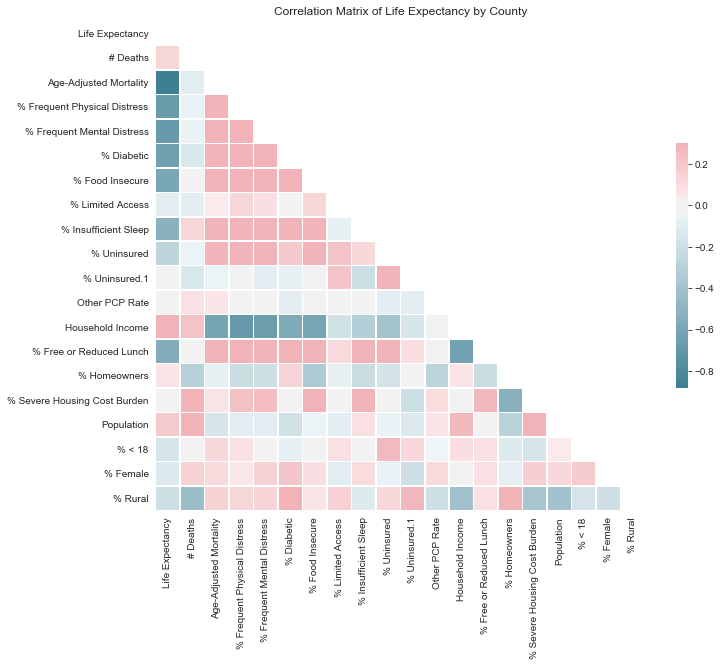

In [652]:
utils.corr_matrix(life_exp)

In [653]:
highly_cor = []
corr = life_exp.corr()
for col,val in zip(corr.index,corr['Life Expectancy']):
    if abs(val) > 0.5:
        highly_cor.append(col)
        
highly_cor

['Life Expectancy',
 'Age-Adjusted Mortality',
 '% Frequent Physical Distress',
 '% Frequent Mental Distress',
 '% Diabetic',
 '% Food Insecure',
 '% Insufficient Sleep',
 'Household Income',
 '% Free or Reduced Lunch']

In [654]:
merged_corr = merged_df.corr()
highly_cor = []
for col,val in zip(merged_corr.index,merged_corr['Life Expectancy']):
    if abs(val) > 0.5:
        highly_cor.append(col)
# Remove columns where it is closely related to life expectancy        
highly_cor.remove('Age-Adjusted Mortality')
highly_cor.remove('Life expectancy raw value')
highly_cor

['Life Expectancy',
 '% Frequent Physical Distress',
 '% Frequent Mental Distress',
 '% Diabetic',
 '% Food Insecure',
 '% Insufficient Sleep',
 'Household Income',
 '% Free or Reduced Lunch',
 'Premature death raw value',
 'Poor or fair health raw value',
 'Poor physical health days raw value',
 'Poor mental health days raw value',
 'Adult smoking raw value',
 'Adult obesity raw value',
 'Physical inactivity raw value',
 'Excessive drinking raw value',
 'Some college raw value',
 'Children in poverty raw value',
 'Children in single-parent households raw value',
 'Injury deaths raw value',
 'Premature age-adjusted mortality raw value',
 'Frequent physical distress raw value',
 'Frequent mental distress raw value',
 'Diabetes prevalence raw value',
 'Food insecurity raw value',
 'Insufficient sleep raw value',
 'Median household income raw value']

In [704]:
model_dataset = merged_df[highly_cor]
renamed = map(lambda x: x.replace('# ','').replace('% ', '').replace(' ','_').replace('-','_').replace('/','_'), list(model_dataset.columns))
model_dataset.columns = renamed
model_dataset.head()

,Life_Expectancy,Frequent_Physical_Distress,Frequent_Mental_Distress,Diabetic,Food_Insecure,Insufficient_Sleep,Household_Income,Free_or_Reduced_Lunch,Premature_death_raw_value,Poor_or_fair_health_raw_value,...,Children_in_poverty_raw_value,Children_in_single_parent_households_raw_value,Injury_deaths_raw_value,Premature_age_adjusted_mortality_raw_value,Frequent_physical_distress_raw_value,Frequent_mental_distress_raw_value,Diabetes_prevalence_raw_value,Food_insecurity_raw_value,Insufficient_sleep_raw_value,Median_household_income_raw_value
0,72.438750,13.923957,13.597365,14.3,14.6,37.220326,49416.0,63.225806,14928.247086,0.202522,...,0.207,0.250746,136.331021,609.0,0.139240,0.135974,0.143,0.146,0.372203,49416
1,70.426037,19.311620,16.927587,17.7,20.1,41.697552,27372.0,74.551815,15397.522311,0.288199,...,0.445,0.386845,148.497030,731.0,0.193116,0.169276,0.177,0.201,0.416976,27372
2,75.056297,13.962862,13.240013,14.4,13.6,38.095369,43148.0,64.112150,10021.508022,0.195170,...,0.255,0.221421,114.979304,506.1,0.139629,0.132400,0.144,0.136,0.380954,43148
3,77.644415,11.841370,11.938509,16.1,10.0,40.158465,62550.0,46.119167,7934.862583,0.174408,...,0.122,0.308528,78.135340,385.3,0.118414,0.119385,0.161,0.100,0.401585,62550
4,74.386212,15.161330,14.633921,15.1,15.2,37.554735,47146.0,58.304042,11348.661611,0.230237,...,0.230,0.298470,107.339535,530.4,0.151613,0.146339,0.151,0.152,0.375547,47146


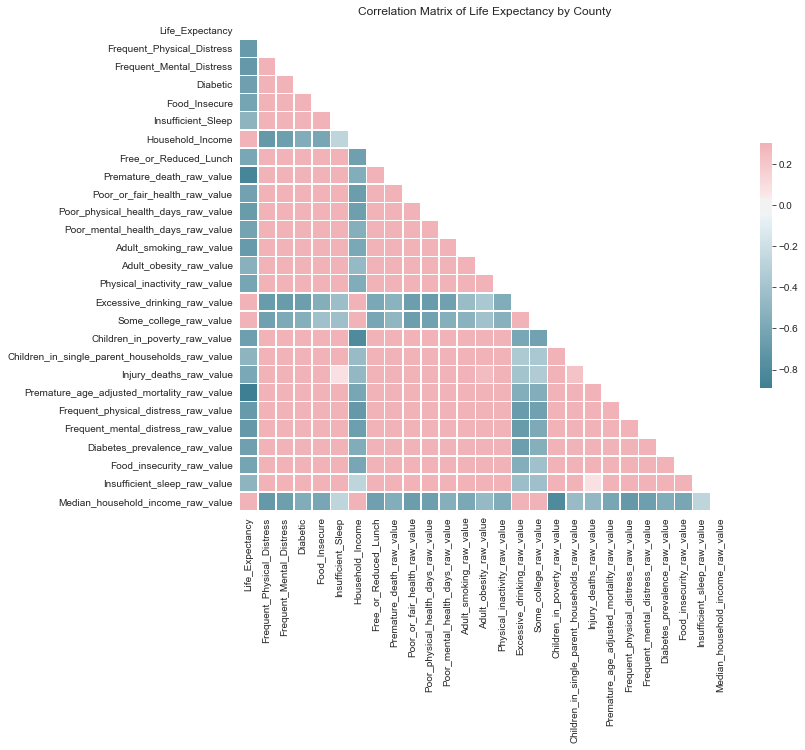

In [756]:
utils.corr_matrix(model_dataset)

In [699]:
# rename columns of the dataframe
renamed = utils.rename_cols(life_exp.columns)
life_exp.columns = renamed

## 1st process on running on excel file 

In [658]:
cros_val = KFold(n_splits=10, random_state=1, shuffle=True)
scaler = MinMaxScaler()
y = life_exp['Life_Expectancy']

xset = life_exp.drop(['State','County','Life_Expectancy','<_18','Uninsured', 'Uninsured.1','Age_Adjusted_Mortality'],axis=1)
xset = xset.select_dtypes(exclude=['object'])
X = scaler.fit_transform(xset)

#X_train, X_test, y_train, y_test = train_test_split(X,y)

linreg = LinearRegression()
baseline = np.mean(cross_val_score(linreg,X,y,scoring='r2',cv=cros_val))
baseline

0.591105115521632

### Run it on other dataset with more relations

We will drop the premature death values thats the negative life expectancy. This is a first model try with colums that are just predictors which would not mean anything in business sense

In [659]:
cros_val = KFold(n_splits=10, random_state=1, shuffle=True)
scaler = MinMaxScaler()
y = model_dataset['Life_Expectancy']

xset = model_dataset.drop(['Life_Expectancy'],axis=1)
#xset = xset.select_dtypes(exclude=['object'])
X = scaler.fit_transform(xset)

#X_train, X_test, y_train, y_test = train_test_split(X,y)

linreg = LinearRegression()
baseline = np.mean(cross_val_score(linreg,X,y,scoring='r2',cv=cros_val))
baseline

0.8211123850284029

In [660]:
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

Run Statsmodel to see p-values

In [661]:

ind_vars = " + ".join(model_dataset.drop('Life_Expectancy',axis=1).columns)

formula = "Life_Expectancy ~ " + ind_vars
model = smf.ols(formula=formula,data=model_dataset).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     504.3
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:00:52   Log-Likelihood:                -3478.8
No. Observations:                2138   AIC:                             7000.
Df Residuals:                    2117   BIC:                             7119.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         87.3822      0.724    120.670      0.000      85.962      88.802
Frequent_Physical_Distress                         0.2615      0.165      1.589      0.112      -0.061       0.584
Frequent_Mental_Distress                          -0.0455      0.126     -0.361      0.718      -0.292       0.201
Diabetic                                           0.0004      0.022      0.016      0.987      -0.043       0.044
Food_Insecure                                     -0.0647      0.011     -5.829      0.000      -0.086      -0.043
Insufficient_Sleep                                -0.0255      0.012     -2.172      0.030      -0.049      -0.002
Household_Income                                3.817e-06   1.93e-06      1.978      0.048    3.33e-08     7.6e-06
Free_or_Reduced_Lunch                              0.0043      0.003      1.620      0.105      -0.001       0.009
Premature_death_raw_value                          0.0002   3.76e-05      4.617      0.000    9.99e-05       0.000
Poor_or_fair_health_raw_value                     -0.0616      2.220     -0.028      0.978      -4.415       4.292
Poor_physical_health_days_raw_value               -0.4116      0.415     -0.992      0.321      -1.226       0.402
Poor_mental_health_days_raw_value                  0.0329      0.288      0.114      0.909      -0.532       0.597
Adult_smoking_raw_value                           -7.8852      1.791     -4.402      0.000     -11.398      -4.372
Adult_obesity_raw_value                           -1.7954      0.969     -1.853      0.064      -3.695       0.104
Physical_inactivity_raw_value                     -3.2095      0.986     -3.256      0.001      -5.143      -1.276
Excessive_drinking_raw_value                       2.7079      1.404      1.929      0.054      -0.045       5.461
Some_college_raw_value                             0.2708      0.350      0.773      0.440      -0.416       0.958
Children_in_poverty_raw_value                     -0.1738      0.766     -0.227      0.821      -1.676       1.328
Children_in_single_parent_households_raw_value    -0.2294      0.409     -0.561      0.575      -1.032       0.573
Injury_deaths_raw_value                           -0.0157      0.002    -10.175      0.000      -0.019      -0.013
Premature_age_adjusted_mortality_raw_value        -0.0195      0.001    -19.893      0.000      -0.021      -0.018
Frequent_physical_distress_raw_value               0.0026      0.002      1.589      0.112      -0.001       0.006
Frequent_mental_distress_raw_value                -0.0005      0.001     -0.361      0.718      -0.003       0.002
Diabetes_prevalence_raw_value                   3.654e-06      0.000      0.016      0.987   

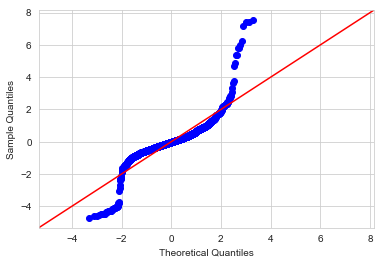

In [586]:
res = model.resid # residuals
fig = sm.qqplot(res,fit=True, line='45')
plt.show()

### On dataset 2

Run the normal linear regression on iterative p value selector dataframe

In [729]:
# iterative p-drop

## 
it_df = utils.iterative_feature_selector(model_dataset)
it_df.drop(['Premature_age_adjusted_mortality_raw_value','Premature_death_raw_value','Injury_deaths_raw_value','Frequent_physical_distress_raw_value'],axis=1,inplace=True)

        
it_df.head()

,Life_Expectancy,Frequent_Physical_Distress,Food_Insecure,Insufficient_Sleep,Household_Income,Poor_physical_health_days_raw_value,Adult_smoking_raw_value,Adult_obesity_raw_value,Physical_inactivity_raw_value,Excessive_drinking_raw_value,Food_insecurity_raw_value,Insufficient_sleep_raw_value,Median_household_income_raw_value
0,72.438750,13.923957,14.6,37.220326,49416.0,4.631397,0.226452,0.348,0.310,0.152663,0.146,0.372203,49416
1,70.426037,19.311620,20.1,41.697552,27372.0,6.005764,0.272547,0.360,0.315,0.120189,0.201,0.416976,27372
2,75.056297,13.962862,13.6,38.095369,43148.0,4.611476,0.224912,0.319,0.271,0.141947,0.136,0.380954,43148
3,77.644415,11.841370,10.0,40.158465,62550.0,4.121717,0.200225,0.357,0.252,0.168962,0.100,0.401585,62550
4,74.386212,15.161330,15.2,37.554735,47146.0,4.977894,0.231776,0.314,0.343,0.130524,0.152,0.375547,47146


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d6e9470>,
      dtype=object)

<Figure size 1152x720 with 0 Axes>

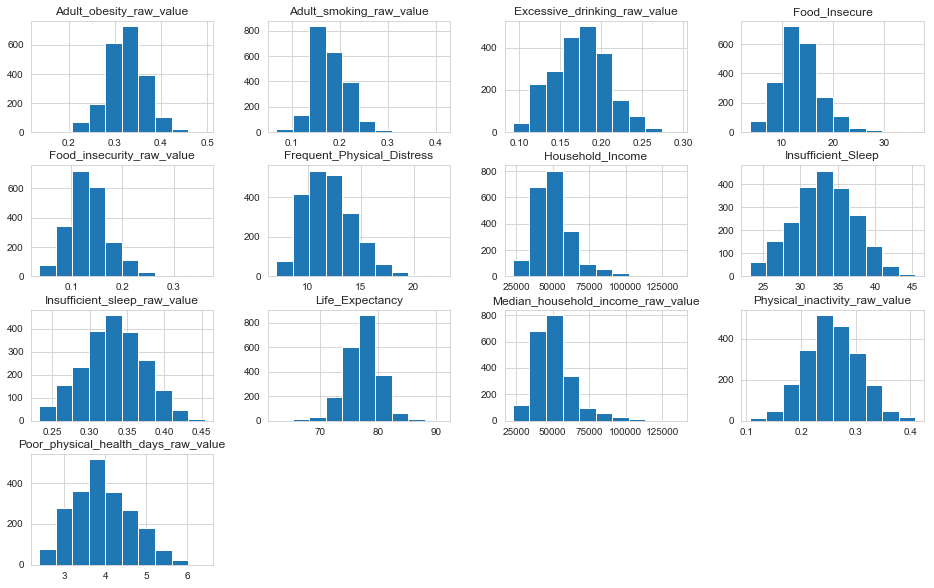

In [730]:
plt.figure(figsize=(16,10))
it_df.hist(figsize=(16,10))

### Run on different dataset
Run on dataset where main correlated ones are dropped

In [731]:
ind_vars = " + ".join(it_df.drop(['Life_Expectancy'],axis=1).columns)

formula = "Life_Expectancy ~ " + ind_vars
model = smf.ols(formula=formula,data=it_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     384.8
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:23:39   Log-Likelihood:                -4318.8
No. Observations:                2138   AIC:                             8658.
Df Residuals:                    2128   BIC:                             8714.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              84.3745      0.854     98.791      0.000      82.700      86.049
Frequent_Physical_Distress              0.2149      0.104      2.072      0.038       0.011       0.418
Food_Insecure                          -0.1423      0.014    -10.179      0.000      -0.170      -0.115
Insufficient_Sleep                     -0.0285      0.015     -1.919      0.055      -0.058       0.001
Household_Income                     1.551e-05   2.43e-06      6.389      0.000    1.08e-05    2.03e-05
Poor_physical_health_days_raw_value    -0.6539      0.314     -2.083      0.037      -1.269      -0.038
Adult_smoking_raw_value               -24.8723      2.326    -10.693      0.000     -29.434     -20.311
Adult_obesity_raw_value                -3.7381      1.339     -2.792      0.005      -6.364      -1.112
Physical_inactivity_raw_value          -7.8793      1.291     -6.103      0.000     -10.411      -5.347
Excessive_drinking_raw_value           11.3446      1.882      6.029      0.000       7.655      15.034
Food_insecurity_raw_value              -0.0014      0.000    -10.179      0.000      -0.002      -0.001
Insufficient_sleep_raw_value           -0.0003      0.000     -1.919      0.055      -0.001     6.2e-06
Median_household_income_raw_value    1.551e-05   2.43e-06      6.389      0.000    1.08e-05    2.03e-05
==============================================================================
Omnibus:                      397.011   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3334.203
Skew:                           0.628   Prob(JB):                         0.00
Kurtosis:                       8.987   Cond. No.                     3.04e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

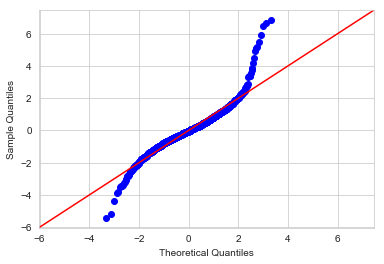

In [732]:
res = model.resid # residuals
fig = sm.qqplot(res,fit=True, line='45')
plt.show()

In [618]:
# Drop high p values
# Keep the columns with 'Diabetic'
# Create the feature engineered dataset
fe_drop = [
    'Frequent_physical_distress_raw_value',
                                 'Premature_age_adjusted_mortality_raw_value',
                                 'Premature_death_raw_value',
                                 'Diabetes_prevalence_raw_value','Frequent_mental_distress_raw_value',
                                 'Household_Income','Children_in_poverty_raw_value',
                                 'Median_household_income_raw_value','Insufficient_Sleep',
                                'Food_insecurity_raw_value','Poor_mental_health_days_raw_value',
                                'Excessive_drinking_raw_value','Some_college_raw_value',
    'Free_or_Reduced_Lunch','Poor_physical_health_days_raw_value','Children_in_single_parent_households_raw_value']


#fe_drop.extend(to_drop)
#fe_drop = list(set(fe_drop))

fe_dataset = model_dataset.drop(fe_drop,axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d8f2b70>,
      dtype=object)

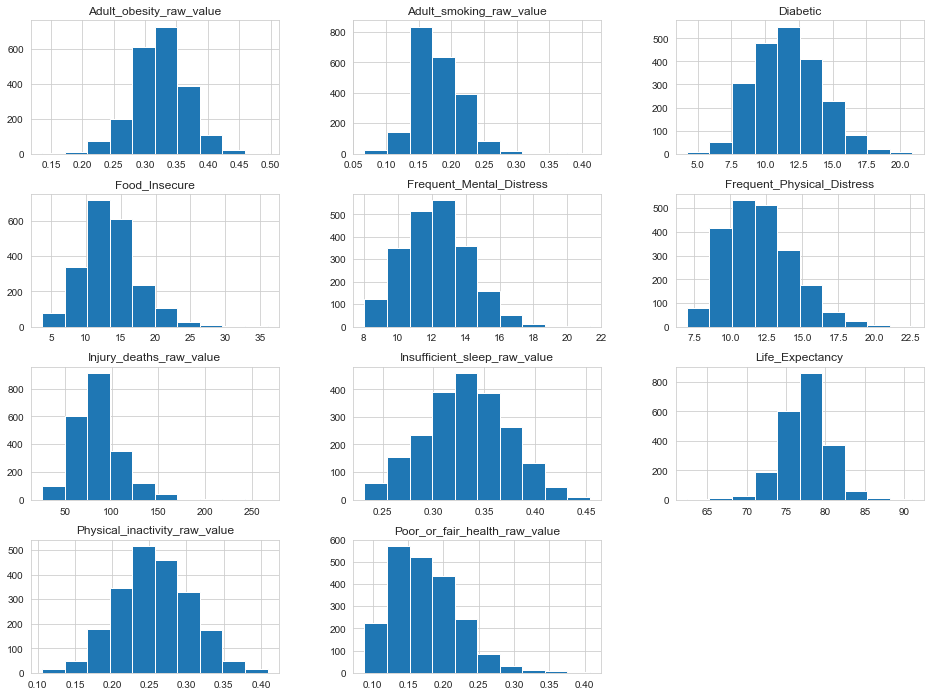

In [759]:
# Check for the normal distributions of model
fe_dataset.hist(figsize=(16,12))

- Poor_of_fair_health_raw_value
- Food_Insecure
- Adult_obesity_raw_value
- Adult_smoking_raw_value
- Frequent_Phtsical_Distress

In [619]:
ind_vars = " + ".join(fe_dataset.drop(['Life_Expectancy'],axis=1).columns)

formula = "Life_Expectancy ~ " + ind_vars
model = smf.ols(formula=formula,data=fe_dataset).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     497.8
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:48:26   Log-Likelihood:                -4062.2
No. Observations:                2138   AIC:                             8146.
Df Residuals:                    2127   BIC:                             8209.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        92.6793      0.412    224.837      0.000      91.871      93.488
Frequent_Physical_Distress        0.0973      0.084      1.156      0.248      -0.068       0.262
Frequent_Mental_Distress         -0.0289      0.076     -0.379      0.705      -0.179       0.121
Diabetic                         -0.0559      0.027     -2.079      0.038      -0.109      -0.003
Food_Insecure                    -0.1506      0.012    -12.516      0.000      -0.174      -0.127
Poor_or_fair_health_raw_value    -7.2200      2.296     -3.144      0.002     -11.723      -2.717
Adult_smoking_raw_value         -14.7852      1.993     -7.420      0.000     -18.693     -10.877
Adult_obesity_raw_value          -3.5818      1.239     -2.891      0.004      -6.012      -1.152
Physical_inactivity_raw_value    -7.6421      1.172     -6.519      0.000      -9.941      -5.343
Injury_deaths_raw_value          -0.0418      0.002    -24.870      0.000      -0.045      -0.039
Insufficient_sleep_raw_value     -8.4663      1.312     -6.451      0.000     -11.040      -5.892
==============================================================================
Omnibus:                      673.127   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6702.667
Skew:                           1.189   Prob(JB):                         0.00
Kurtosis:                      11.342   Cond. No.                     6.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

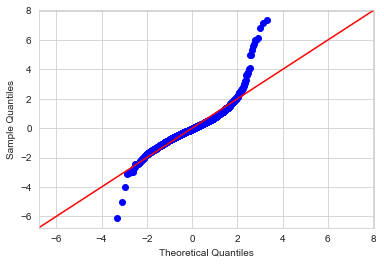

In [620]:
res = model.resid # residuals
fig = sm.qqplot(res,fit=True, line='45')
plt.show()

### First Log 

Take logarithm for skewwed data

In [760]:

logged = np.log(fe_dataset.drop(['Life_Expectancy'],axis=1))
y = fe_dataset['Life_Expectancy']

ind_vars = " + ".join(logged.columns)

logged =  pd.concat([logged,y],axis=1)       
logged = logged.replace([np.inf, -np.inf], -10)
#logged = scaler.fit_transform(logged)


formula = "Life_Expectancy ~ " + ind_vars
model = smf.ols(formula=formula,data=logged).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     517.3
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:32:41   Log-Likelihood:                -4033.2
No. Observations:                2138   AIC:                             8088.
Df Residuals:                    2127   BIC:                             8151.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        81.3407      2.292     35.496      0.000      76.847      85.835
Frequent_Physical_Distress        1.6306      0.984      1.657      0.098      -0.299       3.561
Frequent_Mental_Distress          0.0747      0.925      0.081      0.936      -1.739       1.888
Diabetic                         -0.3136      0.309     -1.014      0.311      -0.920       0.293
Food_Insecure                    -2.0560      0.161    -12.731      0.000      -2.373      -1.739
Poor_or_fair_health_raw_value    -2.4335      0.419     -5.808      0.000      -3.255      -1.612
Adult_smoking_raw_value          -2.2595      0.336     -6.725      0.000      -2.918      -1.601
Adult_obesity_raw_value          -1.5067      0.382     -3.947      0.000      -2.255      -0.758
Physical_inactivity_raw_value    -1.1984      0.297     -4.031      0.000      -1.781      -0.615
Injury_deaths_raw_value          -3.9187      0.148    -26.472      0.000      -4.209      -3.628
Insufficient_sleep_raw_value     -3.1466      0.438     -7.192      0.000      -4.005      -2.289
==============================================================================
Omnibus:                      565.775   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5801.678
Skew:                           0.944   Prob(JB):                         0.00
Kurtosis:                      10.846   Cond. No.                         518.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

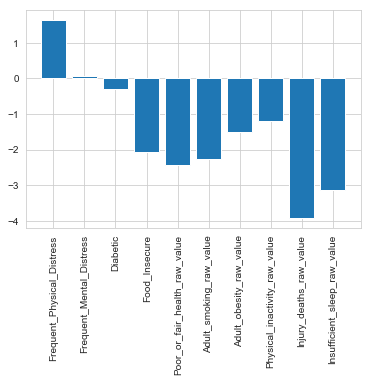

In [736]:
plt.bar(range(len(model.params)-1),model.params[1:])
plt.xticks(np.arange(len(model.params)-1), list(model.params.index)[1:])
plt.xticks(rotation=90)


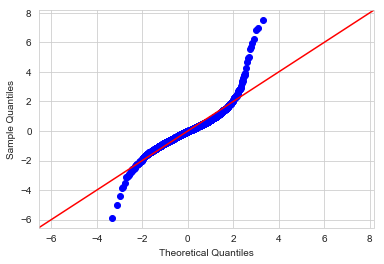

In [623]:
res = model.resid # residuals
fig = sm.qqplot(res,fit=True, line='45')
plt.show()

## Run Sklearn and train-test



In [739]:
cros_val = KFold(n_splits=10, random_state=1, shuffle=True)
scaler = MinMaxScaler()
y = logged['Life_Expectancy']

X = scaler.fit_transform(logged)

X_train, X_test, y_train, y_test = train_test_split(logged.drop('Life_Expectancy',axis=1),y)

linreg = LinearRegression().fit(X_train,y_train)

r2 = r2_score(y_test,linreg.predict(X_test))

In [740]:
r2

0.6953576000825694

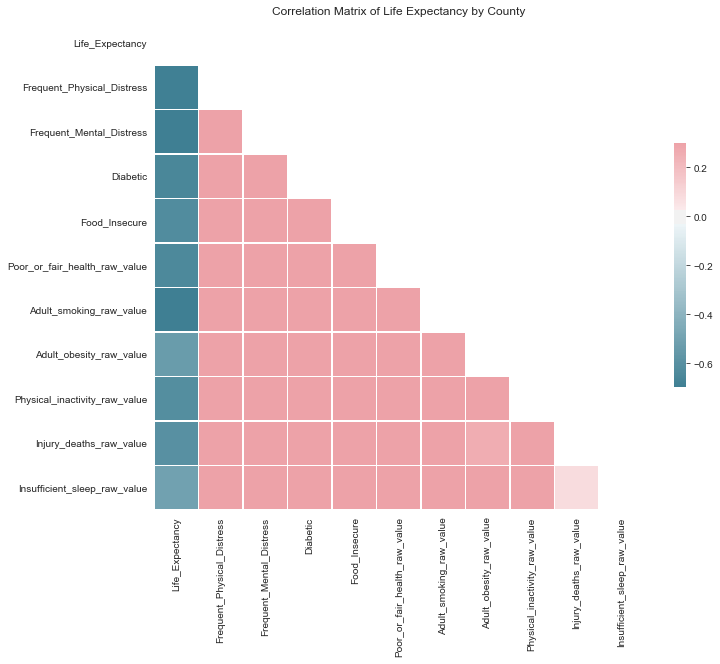

In [626]:
utils.corr_matrix(fe_dataset)

## Run on second big dataframe

#### First check VIF for multicollinearity

In [627]:
cols = list(fe_dataset.columns)
cols.remove('Life_Expectancy')

cols

['Frequent_Physical_Distress',
 'Frequent_Mental_Distress',
 'Diabetic',
 'Food_Insecure',
 'Poor_or_fair_health_raw_value',
 'Adult_smoking_raw_value',
 'Adult_obesity_raw_value',
 'Physical_inactivity_raw_value',
 'Injury_deaths_raw_value',
 'Insufficient_sleep_raw_value']

In [628]:
features = "+".join(cols)

# get y and X dataframes based on this regression:
ymat, Xmat = dmatrices('Life_Expectancy ~' + features, model_dataset, return_type='dataframe')

### Check multicollinearity with VIF

In [629]:

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xmat.values, i) for i in range(Xmat.shape[1])]
vif["features"] = fe_dataset.columns
#vif[vif['VIF Factor'] < 50]
vif

,VIF Factor,features
0,138.091967,Life_Expectancy
1,31.432685,Frequent_Physical_Distress
2,17.585495,Frequent_Mental_Distress
3,3.509829,Diabetic
4,2.058619,Food_Insecure
5,9.658629,Poor_or_fair_health_raw_value
6,4.399422,Adult_smoking_raw_value
7,2.253396,Adult_obesity_raw_value
8,2.708868,Physical_inactivity_raw_value
9,1.468946,Injury_deaths_raw_value


As you can see there is not a high multicollinearity on our df

### Run a Polynomial Regression

In [742]:
X =  scaler.fit_transform(fe_dataset.drop(['Life_Expectancy'],axis=1))
y = model_dataset['Life_Expectancy']
X_train, X_test, y_train, y_test = train_test_split(X,y)



In [743]:
degrees = [2,3,4]
r2 = []
models = []
for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_fin = poly.fit_transform(X_train)
    X_t = poly.fit_transform(X_test)
    poly_reg = LinearRegression().fit(X_fin,y_train)
    y_pred = poly_reg.predict(X_t)
    res = {degree: r2_score(y_test,y_pred)}
    models.append(poly_reg)
    print(res)
    r2.append(res)

{2: 0.704876634761634}
{3: 0.5949073563020855}
{4: -8.096908753458875}


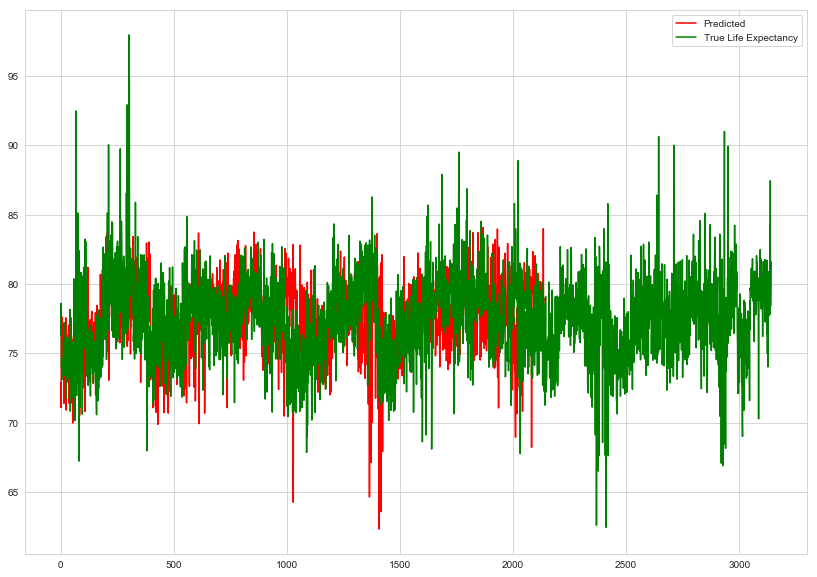

In [744]:
plt.figure(figsize=(14,10))
poly = PolynomialFeatures(2)
reg =  models[0]
X_t = poly.fit_transform(X)
ypred = reg.predict(X_t)
plt.plot(ypred, color='r',label="Predicted")
plt.plot(life_exp['Life_Expectancy'], color='g',label="True Life Expectancy")
plt.legend()

## Feature elimination

In [745]:
X_second =  scaler.fit_transform(fe_dataset.drop('Life_Expectancy',axis=1))
y = fe_dataset['Life_Expectancy']

In [746]:
rfecv = RFECV(estimator=linreg, step=1, cv=cros_val, scoring='r2')
rfecv.fit(X_second, y)
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


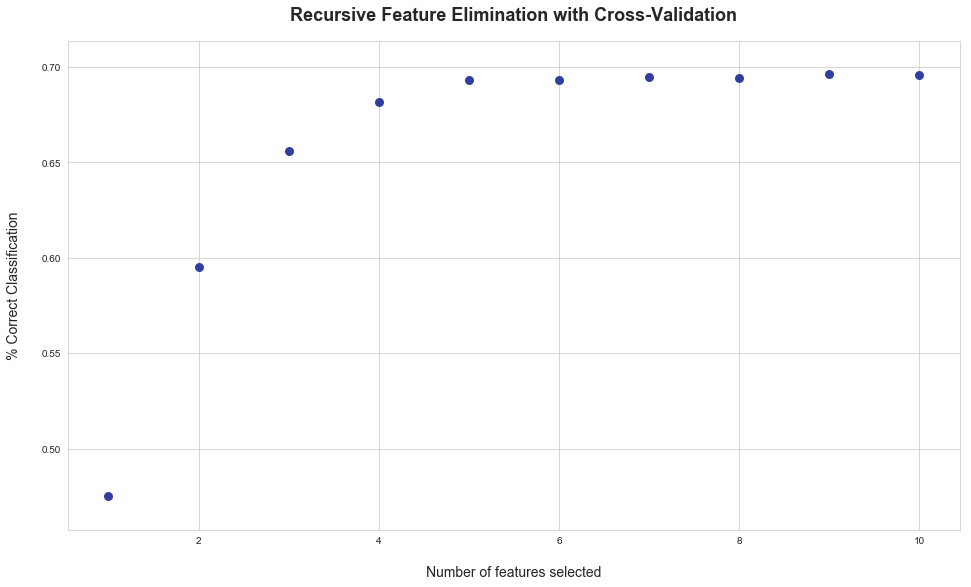

In [747]:

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.scatter(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [748]:
print(np.where(rfecv.support_ == False)[0])
second_df.drop(second_df.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[1]


In [749]:
second_df.head()

,State,Life_Expectancy,Deaths,Age_Adjusted_Mortality,Frequent_Physical_Distress,Frequent_Mental_Distress,Diabetic,Food_Insecure,Limited_Access,Insufficient_Sleep,...,Uninsured.1,Other_PCP_Rate,Household_Income,Free_or_Reduced_Lunch,Homeowners,Severe_Housing_Cost_Burden,Population,<_18,Female,Rural
0,Alabama,76.330589,815.0,438.7,12.824434,12.638357,14.2,13.4,11.991125,35.905406,...,2.476190,30.62842,58343.0,47.931664,73.287736,12.645206,55504,23.937014,51.342246,42.002162
1,Alabama,78.599498,2827.0,348.4,12.622002,12.822558,11.3,12.3,5.424427,33.305868,...,3.238027,52.20385,56607.0,45.079131,72.859338,12.795922,212628,21.848487,51.452772,42.279099
2,Alabama,75.779457,451.0,469.8,16.216160,14.632311,18.0,23.2,10.739667,38.563167,...,2.901424,23.74357,32490.0,73.769808,62.506800,13.586765,25270,20.763751,47.229917,67.789635
3,Alabama,73.928271,445.0,563.7,13.162968,12.854036,14.9,15.8,2.601627,38.148865,...,2.619447,92.64161,45795.0,65.329687,75.361481,8.733889,22668,20.606141,46.453150,68.352607
4,Alabama,74.597767,1050.0,501.8,13.720057,13.827943,14.3,11.0,2.880150,35.945010,...,3.430136,18.96127,48253.0,53.311793,78.521025,8.194495,58013,23.349939,50.688639,89.951502


 Hi p values are Rural, homeowners, Limited Access, Frequent_Physical_Distress

In [750]:
cros_val = KFold(n_splits=10, random_state=1, shuffle=True)
scaler = MinMaxScaler()

poly = PolynomialFeatures(2)



y = fe_dataset['Life_Expectancy']
X = scaler.fit_transform(fe_dataset.drop('Life_Expectancy',axis=1))

X_train, X_test, y_train, y_test = train_test_split(X,y)

X_fin = poly.fit_transform(X_train)
X_t = poly.fit_transform(X_test)

lasso = Lasso(alpha=0.05)

In [751]:
lasso_model = lasso.fit(X_fin,y_train)
preds = lasso_model.predict(X_t)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test,preds)
mse = mean_squared_error(y_test,preds)

In [752]:
print(r2)
print(mse)

0.6637462004638275
2.7693824592266076


In [754]:
ridge = Ridge(alpha=0.05)
ridge_model = ridge.fit(X_fin,y_train)
preds = lasso_model.predict(X_t)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test,preds)
mse = mean_squared_error(y_test,preds)

In [755]:
print(r2)
print(mse)

0.6637462004638275
2.7693824592266076
